# XGBoost regression models

## XGBoost regression theory

In machine learning, ensemble models perform better than individual models with high probability. An ensemble model combines different machine learning models into one. The Random Forest is a popular ensemble that takes the average of many Decision Trees via bagging. Bagging is short for “bootstrap aggregation”, meaning that samples are chosen with replacement (bootstrapping), and combined (aggregated) by taking their average.
Boosting is a strong alternative to bagging. Instead of aggregating predictions, boosters turn weak learners into strong learners by focusing on where the individual models (usually Decision Trees) went wrong. In Gradient Boosting, individual models train upon the residuals, the difference between the prediction and the actual results. 

```{figure} ../media/images/treesexpl.png
---
width: 600px
name: treeexpl
---
This picture displays the final surface/f(x) a individual tree might generate
```

[Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees When a decision tree is the weak learner, the resulting algorithm is called gradient boosted trees, which usually outperforms random forest. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Instead of aggregating trees, gradient boosted trees learns from errors during each boosting round.
[XGBoost](https://en.wikipedia.org/wiki/XGBoost) is short for “eXtreme Gradient Boosting”. The “eXtreme” refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. 

In addition, XGBoost includes a unique split-finding algorithm to optimize trees, along with built-in regularization that reduces overfitting. Generally speaking, XGBoost is a faster, more accurate version of Gradient Boosting.

Boosting performs better than bagging on average, and Gradient Boosting is arguably the best boosting ensemble. Since XGBoost is an advanced version of Gradient Boosting, and its results are unparalleled, it’s arguably the best machine learning ensemble that we have.

Below, an example of a tree obtained in this notebook is shown:

```{figure} ../media/images/tree-example.png
---
width: 600px
name: tree
---
This picture displays some leaves of a regression tree, where the input variables are the PCs of a regional predictor
```

In [8]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.tree import plot_tree

# append sscode to path
import sys, os
sys.path.insert(0, '/Users/administrador/Documents/geocean-nz-ss')
data_path = '/Volumes/ToshibaJT/geocean-nz-ss/data'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_region_reduced, \
    default_location, default_evaluation_metrics
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.xgboost import XGBoost_Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Load the data

As always, we load the three used datasets, which are the Moana v2 hindcast nearshore, the CFSR sea-level-pressure fields and winds (u10 and v10) and the UHSLC tgs validators, again setting the `plot` parameter to `False`.

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=(False,False,False),
    load_predictor_files=(True,
        [data_path+'/cfsr/CFSR_MSLP_daily.nc',data_path+'/cfsr/CFSR_WINDs_daily.nc']
    ) # load previously calculated winds
)


 loading previously saved atmospheric data from (True, ['/home/javitausia/Documentos/geocean-nz-ss/data/cfsr/CFSR_MSLP_daily.nc', '/home/javitausia/Documentos/geocean-nz-ss/data/cfsr/CFSR_WINDs_daily.nc']) 


 loading the Moana v2 hindcast data... 


 loading the UHSLC tidal guages... 



## Calculate regional PCA

Now, with the loaded data, we can calculate the regional PCs, so they can be used to reconstruct the storm surge all over New Zealand, using the same atmospheric predictor.

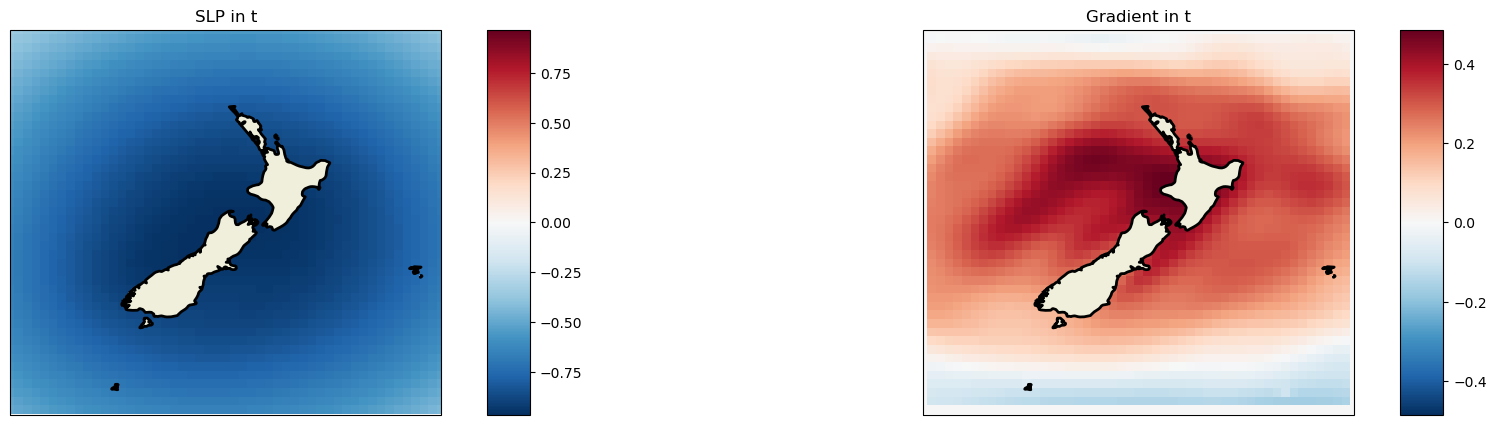

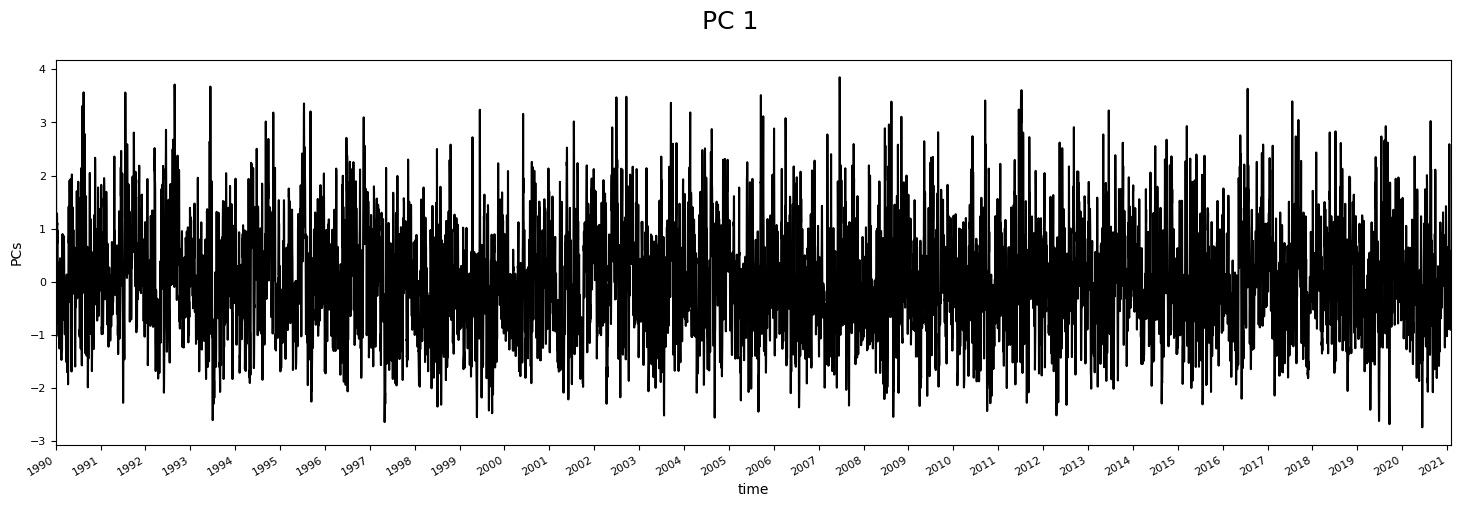

In [3]:
# load / calculate the regional pcs
pcs_data_regional, pcs_scaler_regional = PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp.SLP, 
    calculate_gradient=True,
    time_lapse=1, # 1 equals to NO time delay                    
    time_resample='1D', # daily resampling
    region=(True,default_region_reduced),
    pca_plot=(True,False,1),
    pca_ttls=('SLP in t','Gradient in t'),
    verbose=False
).pcs_get()

## XGBoost regression with regional predictor

In the following cell, a XGBoost regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics/regional_models` folder, with the name `stats_xgboost_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

In [4]:
run = False
if run:
    # perform the XGBoost-Regression (regional)
    metrics_regional = [] # save regional metrics
    pcs_to_use_regional = [] # save used pcs (f-regression)
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    )[::300]
    # perform the XGBoost regression over all the sites
    for site in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=site)\
            .load().resample(time='1D').max()
        metrics, model, pcs_to_use = XGBoost_Regression(
            pcs_data_regional, ss_moana, # use default attributes
            verbose=False, plot_results=True
        ) # using the regional-pre-loaded pcs
        metrics_regional.append(list(metrics.values())) # save site metrics
        pcs_to_use_regional.append(pcs_to_use) # save used pcs
    # now, save all in xarray.Dataset
    sites_metrics_regional = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_regional[metric] = (('site'),np.array(metrics_regional)[:,im])
    sites_metrics_regional['latitude'] = (
        ('site'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat.values
    )
    sites_metrics_regional['longitude'] = (
        ('site'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon.values
    )
    # save the metrics
    metrics_dataset_regional = xr.Dataset(
        sites_metrics_regional,coords={'site':sites_regional}
    )
    # local copys
    if True:
        metrics_dataset_regional.to_netcdf(
            data_path+'/statistics/regional_models/stats_xgboost_regional_daily.nc'
        ) # save metrics in all the stations
        np.save(
            data_path+'/statistics/regional_models/pcs_xgboost_regional_daily.npy',
            np.array(pcs_to_use_regional)
        ) # save pcs used in the xgboost regressions
else:
    metrics_dataset_regional = xr.open_dataset(
        data_path+'/statistics/regional_models/stats_xgboost_regional_daily.nc'
    )

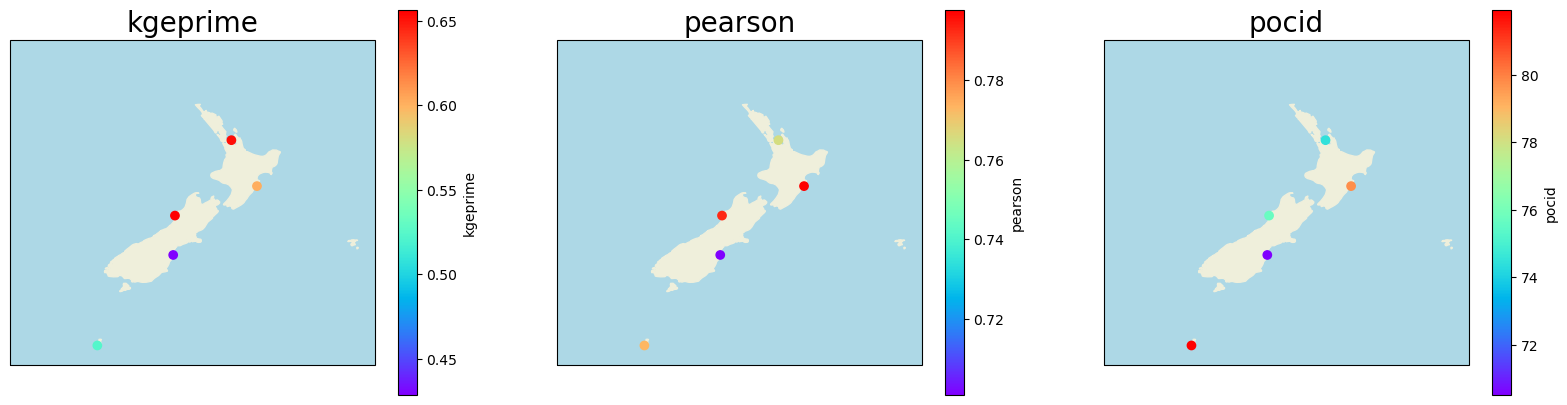

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_regional,
               plot_stats=['kgeprime','pearson','pocid'],
               cmap='rainbow')

with the code below, we can plot the PCs used with the linear regression:

```python
    pcs_to_use_regional = np.load(
        data_path+'/statistics/regional_models/pcs_xgboost_regional_daily.npy',
        allow_pickle=True
    )
    max_pcs = max([np.max(array) for array in pcs_to_use_regional])
    pcs_importance = np.zeros((len(pcs_to_use_regional),max_pcs))
    for i,array in enumerate(pcs_to_use_regional):
        for pc in range(max_pcs):
            try:
                pcs_importance[i,pc] = (max_pcs-np.where(array==pc)[0])/max_pcs
            except:
                continue
    fig, ax = plt.subplots(figsize=(20,10))
    pcol = ax.pcolor(pcs_importance.T[:50,:],cmap='Spectral')
    fig.colorbar(pcol)
    # ax.set_yticks(np.arange(0,50,5)+0.5)
    # ax.set_yticklabels(np.arange(0,50,5)+1,fontsize=16)
    # ax.set_xticks(np.arange(20,len(pcs_to_use_regional))[::50]+0.5)
    # ax.set_xticklabels(np.arange(
    #     20,len(load_cfsr_moana_uhslc.predictand.site.values),1
    # )[::50],fontsize=16)
    # plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
    plt.show()
```

### XGBoost regression in the UHSLC tidal gauges + validation

This part explanation is similar to the one available at **MultiLinear regression models (models_linear.ipynb)** and **KNN regressor models (models_knn.ipynb)**!!

But in this case, we could also use the trained agent to see what are the best parameters for our XGBoost model, in all the locations of the tidal gauges, but training the model with the Moana v2 hindcast.

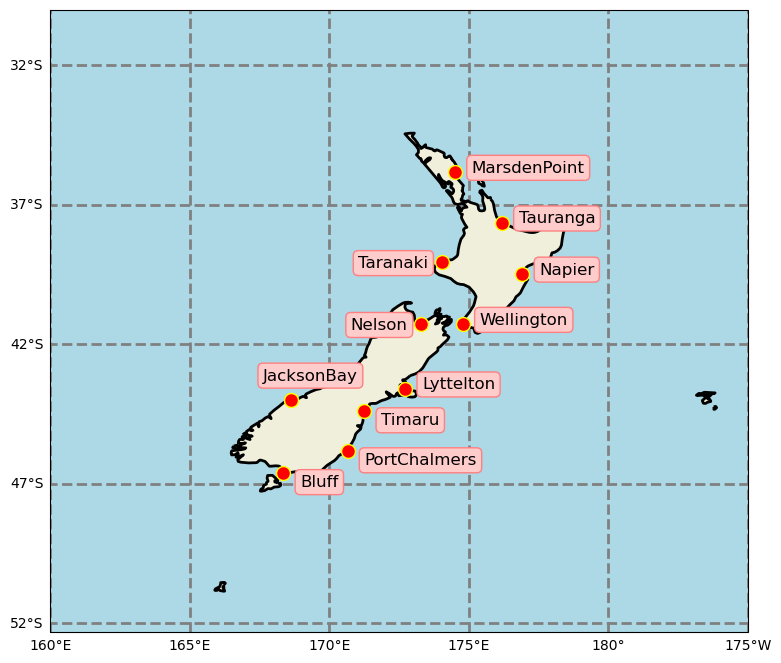

In [6]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)

Assembling matrix
Start 0

 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 10, 10) 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculating PCs matrix with shape: 
 (11351, 900) 

Computing using CPU
matrix (11351, 900)
PCs (11351, 900)
comp (900, 900)
var (900,)
lon <xarray.DataArray 'longitude' (longitude: 10)>
array([166. , 166.5, 167. , 167.5, 168. , 168.5, 169. , 169.5, 170. , 170.5],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 166.0 166.5 167.0 167.5 ... 169.5 170.0 170.5
lat <xarray.DataArray 'latitude' (latitude: 10)>
array([-49. , -48.5, -48. , -47.5, -47. , -46.5, -46. , -45.5, -45. , -44.5],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -49.0 -48.5 -48.0 -47.5 ... -45.5 -45.0 -44.5
time (11351,)

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



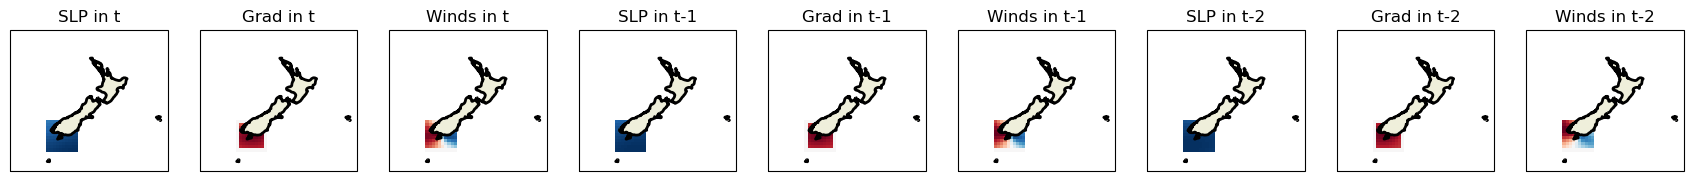

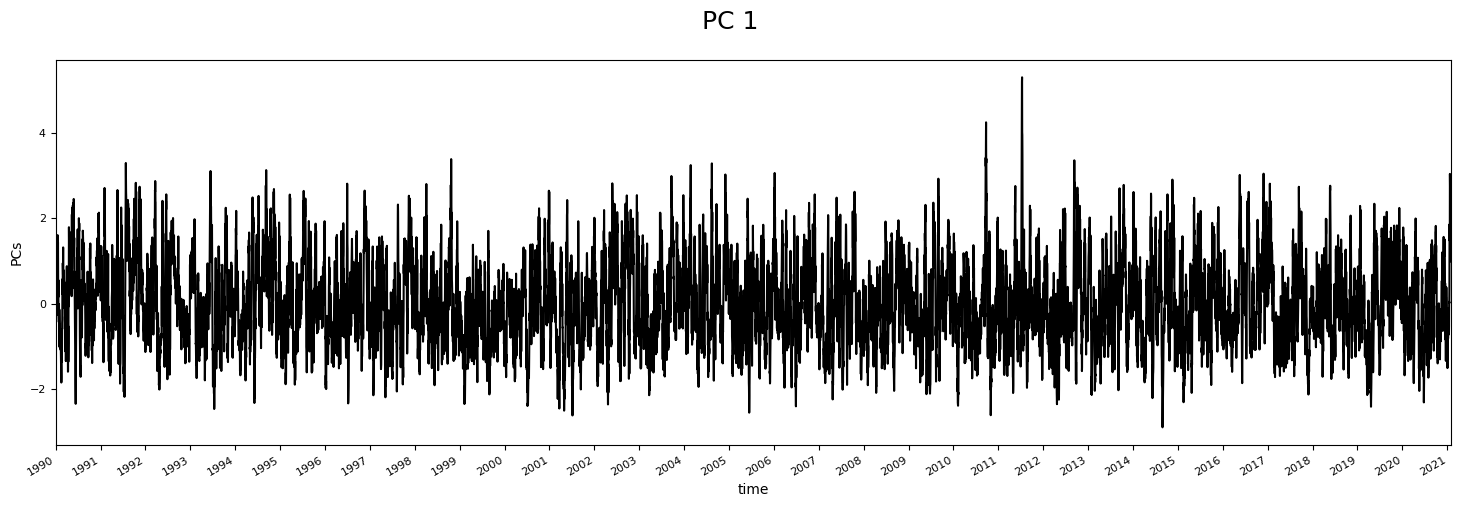


 22 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 0.07, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 



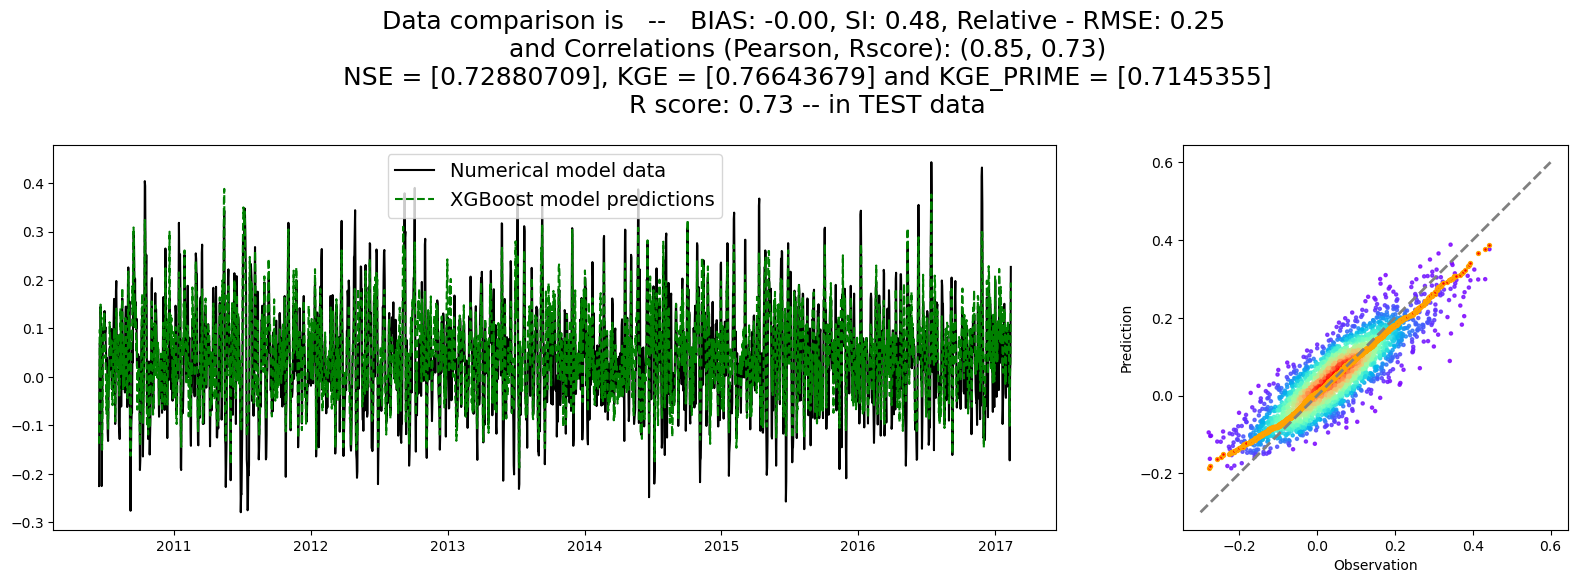

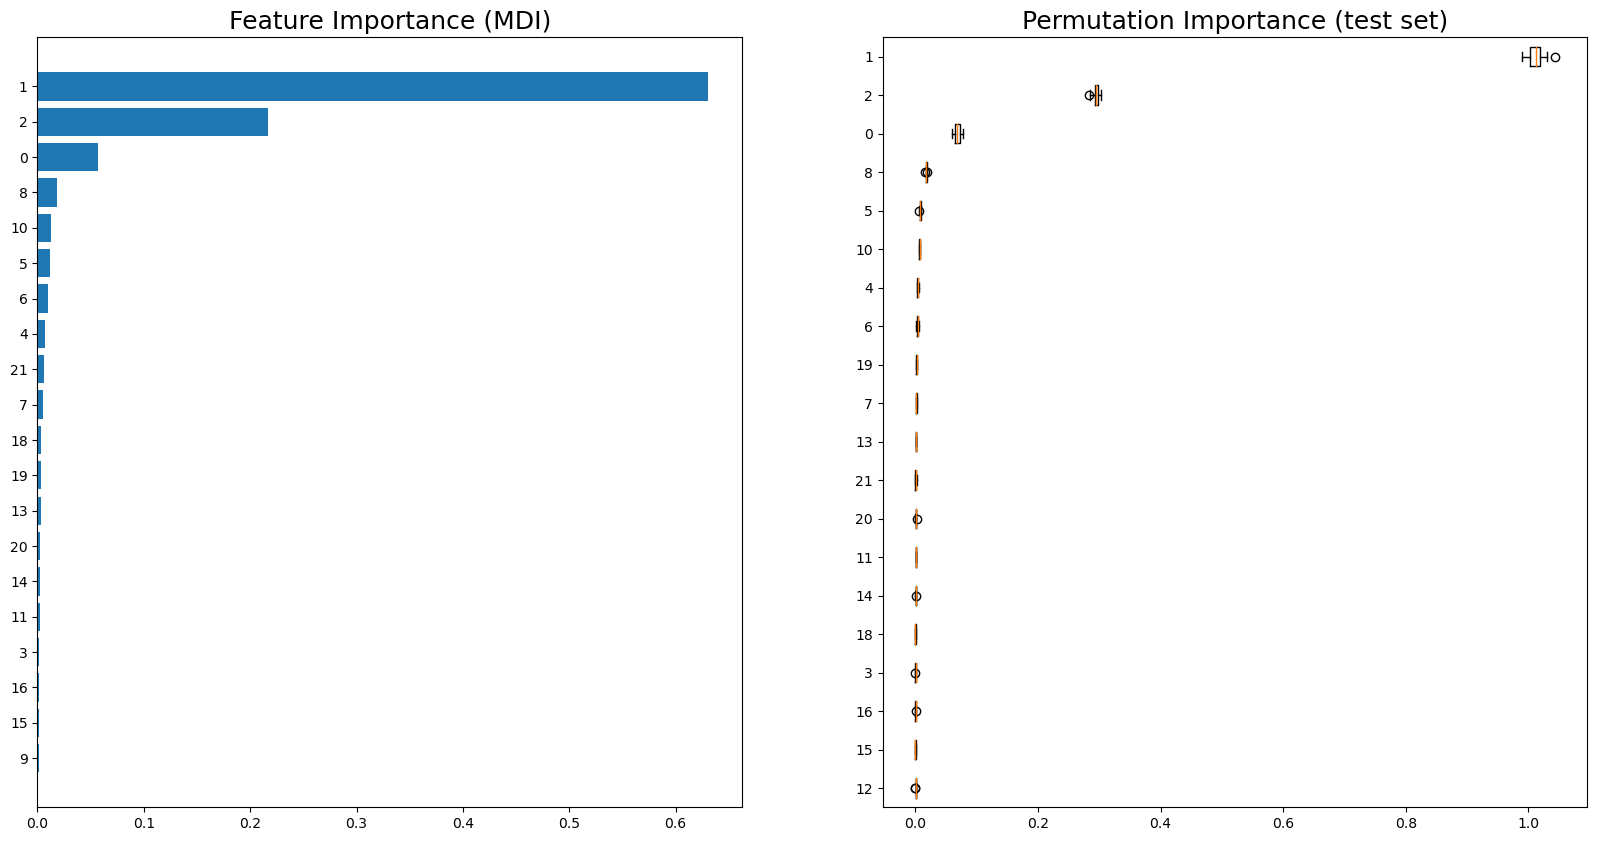

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.73)
 NSE = [0.72880709], KGE = [0.76643679] and KGE_PRIME = [0.7145355]
 R score: 0.73 -- in TEST data


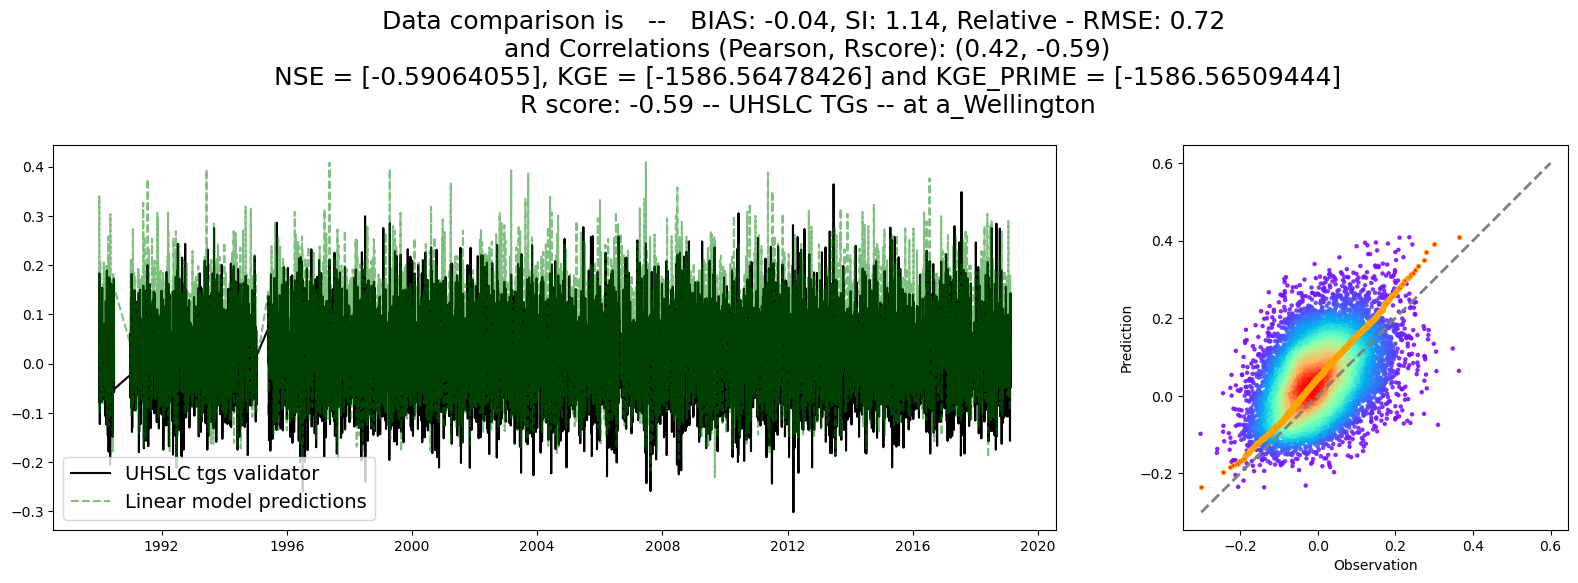

Assembling matrix
Start 0

 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 10, 10) 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculating PCs matrix with shape: 
 (11351, 900) 

Computing using CPU
matrix (11351, 900)
PCs (11351, 900)
comp (900, 900)
var (900,)
lon <xarray.DataArray 'longitude' (longitude: 10)>
array([176. , 176.5, 177. , 177.5, 178. , 178.5, 179. , 179.5, 180. , 180.5],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 176.0 176.5 177.0 177.5 ... 179.5 180.0 180.5
lat <xarray.DataArray 'latitude' (latitude: 10)>
array([-40. , -39.5, -39. , -38.5, -38. , -37.5, -37. , -36.5, -36. , -35.5],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -40.0 -39.5 -39.0 -38.5 ... -36.5 -36.0 -35.5
time (11351,)

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



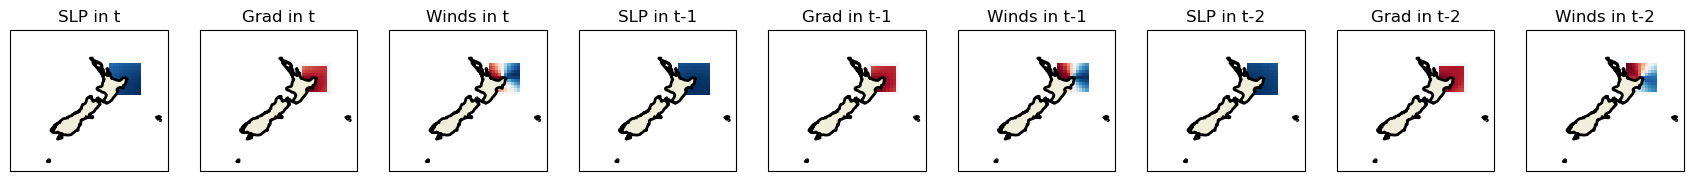

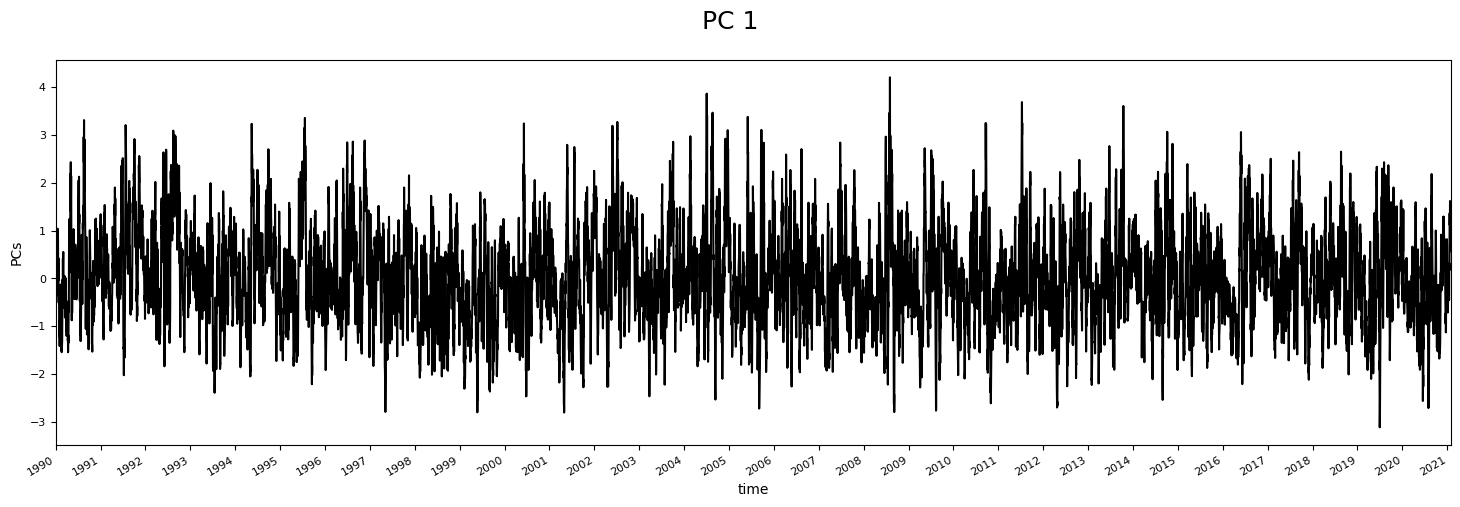


 25 PCs (0.98 expl. variance) will be used to train the model!! 


 XGBoost regression with {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 0.07, 'learning_rate': 0.1, 'loss': 'ls'} parameters... 



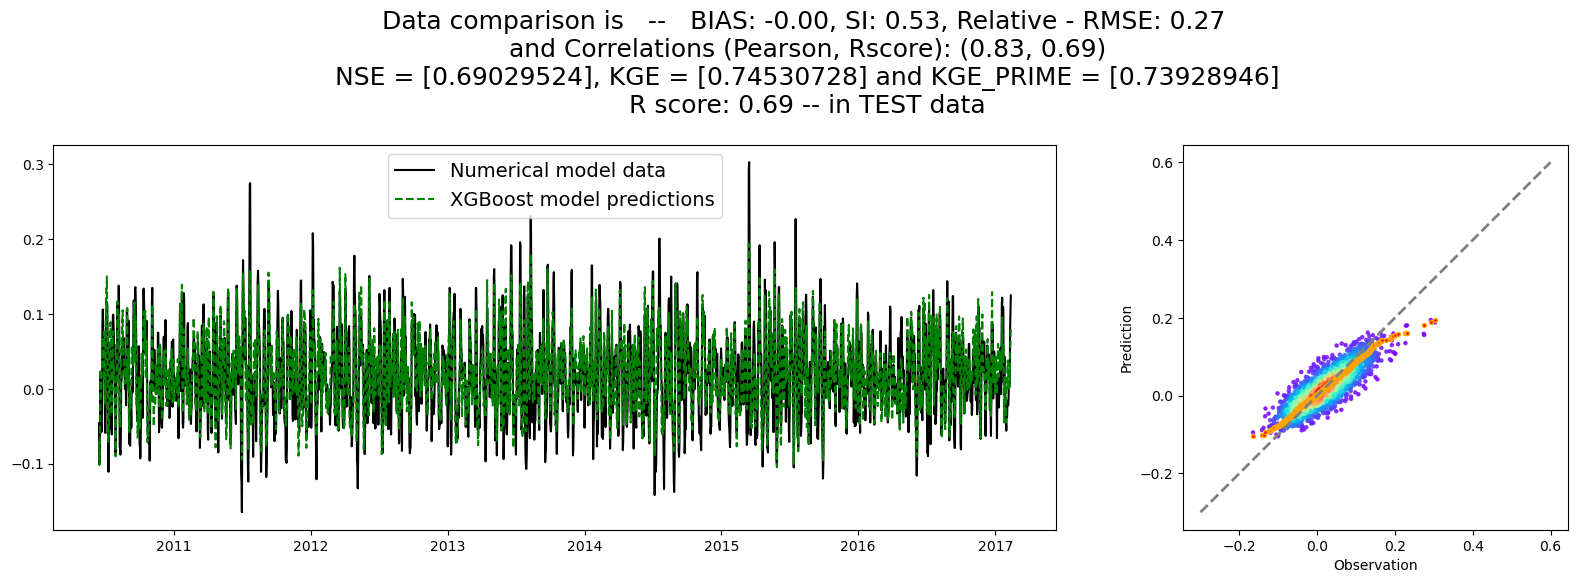

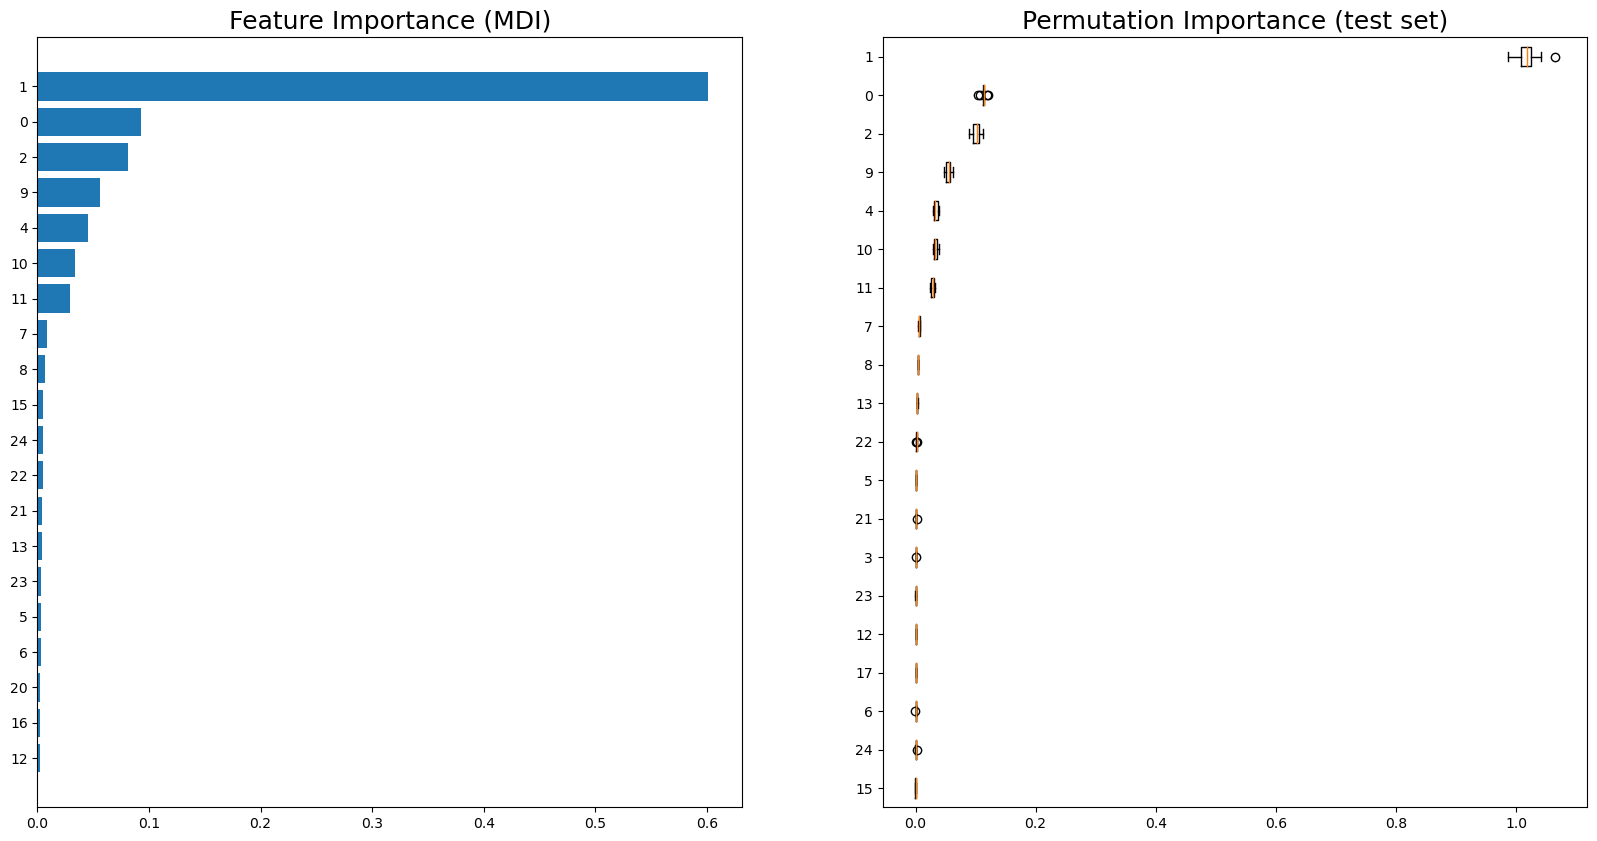

Data comparison is   --   BIAS: -0.00, SI: 0.53, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.83, 0.69)
 NSE = [0.69029524], KGE = [0.74530728] and KGE_PRIME = [0.73928946]
 R score: 0.69 -- in TEST data


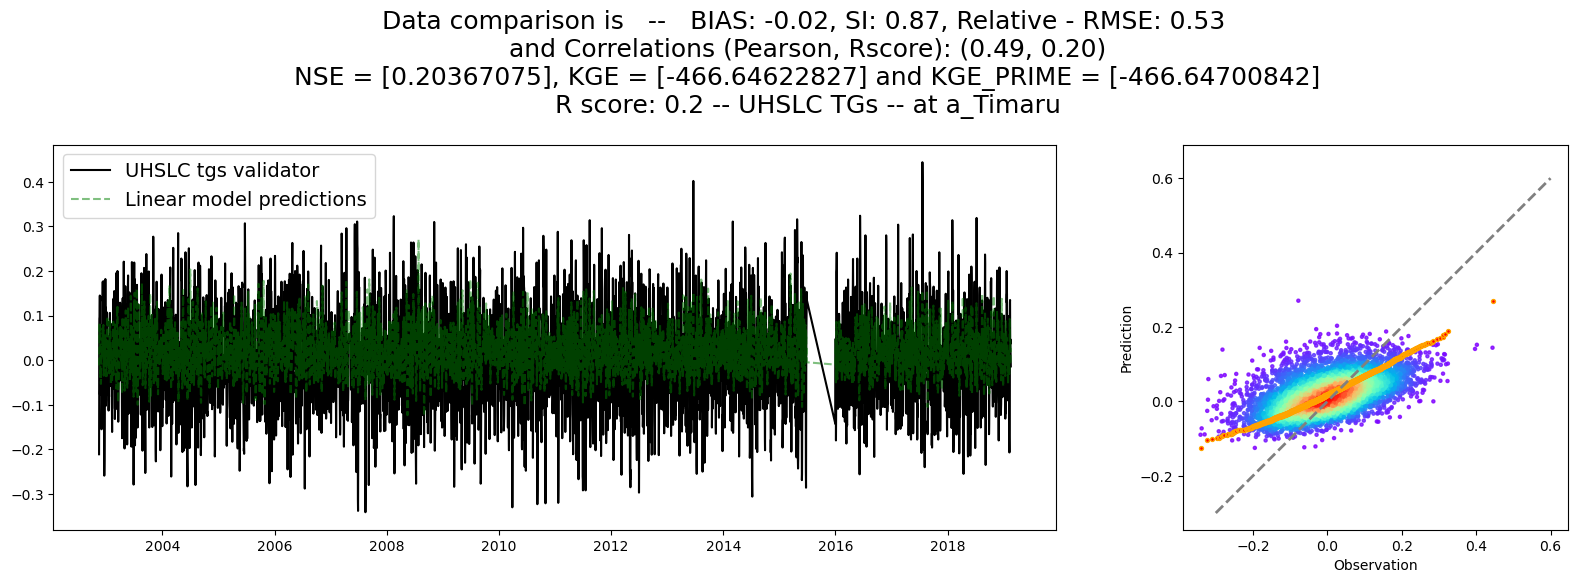

In [11]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)[::20]
for istat,stat in enumerate(sites_to_analyze):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    metrics, model, pcs_to_use = XGBoost_Regression(
        PCA_DynamicPred(
            load_cfsr_moana_uhslc.predictor_slp.SLP, 
            calculate_gradient=True, time_lapse=3,
            wind=load_cfsr_moana_uhslc.predictor_wind,
            site_location=(ss_moana.lon.values[0],ss_moana.lat.values[0]),
            region=(True, (
                ss_moana.lon.values[0]-2.5,
                ss_moana.lon.values[0]+2.5,
                ss_moana.lat.values[0]-2.5,
                ss_moana.lat.values[0]+2.5
            )),
            pca_plot=(True,False,1), verbose=True,
            pca_ttls=['SLP in t','Grad in t','Winds in t',
                      'SLP in t-1','Grad in t-1','Winds in t-1',
                      'SLP in t-2','Grad in t-2','Winds in t-2']
            ).pcs_get()[0],
        ss_moana, percentage_PCs=0.98, plot_results=True, verbose=True,
        model_metrics=default_evaluation_metrics, train_size=0.7,
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        )
)